In [1]:
import sys
sys.path.append("../..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import statsmodels.api as sm
from scipy.stats import boxcox, pearsonr
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from joblib import Parallel, delayed, parallel_backend
# from statsmodels.sandbox.tools import cross_val
import gc
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.linear_model import Lasso, LinearRegression, LassoLars
import patsy
from sklearn.utils import shuffle

# from modeldb.sklearn_native import CrossValidationScore
from sklearn.model_selection import GridSearchCV
import traceback
import math

from sklearn.model_selection import cross_val_score
from coh_tools import *
from get_data import get_dataframes

%matplotlib inline

style.use("tableau-colorblind10")
# style.use("seaborn-white")

/home/julien/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
dataframes = get_dataframes("/home/julien/school/lab/opto_data_analysis", 
                     "/mnt/hdd2tb/lab/elife/data", only_paired=True)

theta
beta
gamma
high_gamma


In [3]:
dataframes["theta"].head()

Initial_coh  Distance  Coh_proj     Phase      PC1a       PC2a  \
1919      0.524316  5.830952  0.407454  0.191729  7.749815  -0.009647   
6408      0.158393  5.830952  0.105235  0.853124  6.627555  13.057726   
10897     0.163833  5.830952  0.120693  0.648843  5.155398  13.057248   
15386     0.216833  5.830952  0.161259  0.049537  4.432064  11.666225   
19875     0.114315  5.830952  0.076719  0.134857  4.815078  15.029962   

           PC1b      PC2b  Coh_diff_mag  Coh_sum_mag  ...  Delays  Monkeys  \
1919  -3.851454 -4.534694      0.377880     1.331394  ...    10.0        G   
6408  -8.157464  2.497598      0.554096     0.853207  ...    10.0        G   
10897 -6.205753 -1.616815      0.564652     0.895323  ...    10.0        G   
15386 -3.604825 -3.235057      0.528074     0.961196  ...    10.0        G   
19875 -6.249463  4.734989      0.521524     0.760831  ...    10.0        G   

      Block_num       Experiment_block_key Both_M1  Both_S1  cond_diff_Y  \
1919        1.0  MonkeyG_20150908_Session2     0.0      0.0    -0.056512   
6408        2.0  MonkeyG_20150908_Session2     0.0      0.0     0.224497   
10897       3.0  MonkeyG_20150908_Session2     0.0      0.0     0.192370   
15386       4.0  MonkeyG_20150908_Session2     0.0      0.0     0.186996   
19875       5.0  MonkeyG_20150908_Session2     0.0      0.0     0.188023   

       cond_diff_percent_Y    diff_Y  diff_percent_Y  
1919             -0.107782 -0.365923       -0.697906  
6408              1.417346  0.005440        0.034347  
10897             1.174184  0.053000        0.323503  
15386             0.862396 -0.102519       -0.472800  
19875             1.644789 -0.001777       -0.015542  

[5 rows x 21 columns]

In [4]:
norm_feat = "Monkeys" # "Experiment_block_key" # 
for band in ["theta", "beta", "gamma", "high_gamma"]:
    for y in ["cond_diff_Y", "cond_diff_percent_Y", "diff_Y", "diff_percent_Y", 
              "Coh_proj", "Coh_diff_mag"]:
        dataframes[band][y] = dataframes[band].groupby(norm_feat)[y].transform(lambda x: (x - x.mean()) / x.std())
        
# norm_feat = "Experiment_block_key"
# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     for y in ["Coh_proj", "PC1a", "PC1b", "PC2a", "PC2b"]:
#         dataframes[band][y] = dataframes[band].groupby(norm_feat)[y].transform(lambda x: (x - x.mean()) / x.std())

## Lars lasso path

In [5]:
formula = "(Initial_coh + PC2a + PC2b + Coh_proj +\
        PC1b + PC1a + Phase + Distance + Block_num + Delays + Both_M1 + Both_S1 + \
        Coh_diff_mag) - 1"
response = "cond_diff_Y"

alphas = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
active = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
coefs = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
n_iter = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:
    
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1)
    scaler = StandardScaler()
    y = scaler.fit_transform(y).flatten()
    
    alphas[band], active[band], coefs[band], n_iter[band]=linear_model.lars_path(x, y, method='lasso',
                                                   verbose=0, return_n_iter=True)


theta
Initial_coh
Coh_diff_mag
PC2a
Coh_proj
Delays
PC2b
Distance
PC1b
Both_M1
Both_S1
Block_num
Phase
PC1a


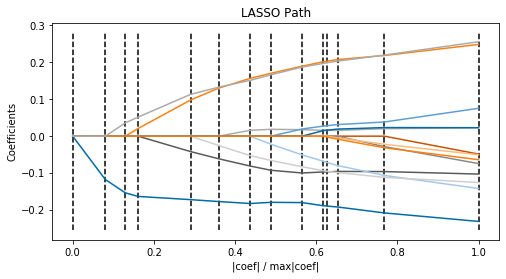

beta
Coh_diff_mag
Initial_coh
PC2a
PC2b
Both_S1
PC1b
Phase
PC1a
Distance
Block_num
Both_M1
Delays
Coh_proj


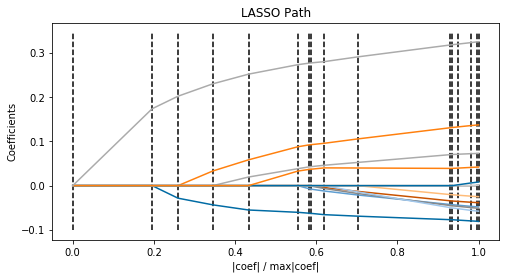

gamma
Coh_diff_mag
Initial_coh
Delays
Coh_proj
PC2b
Both_S1
PC1b
Block_num
Distance
Phase
PC1a
PC2a
Both_M1


high_gamma
Coh_proj
Coh_diff_mag
Delays
PC1b
Phase
Both_S1
PC2b
Both_M1
PC1a
Distance
PC2a
Initial_coh
Block_num


In [6]:
dm = patsy.dmatrix(formula, dataframes[band][:10])
features = dm.design_info.column_names

for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    for feature_i in active[band]:
        print(features[feature_i])
#     print()
    
    xx = np.sum(np.abs(coefs[band].T), axis=1)
    xx /= xx[-1]

    plt.figure(figsize=(8, 4))
    plt.plot(xx, coefs[band].T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.show()

## Lasso CV

In [17]:
models = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
opts = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    y = dataframes[band][response].to_numpy().reshape(-1, 1)
    scaler = StandardScaler()
    y = scaler.fit_transform(y)
    
    x, y = shuffle(x, y)
    
    opt = BayesSearchCV(Lasso(fit_intercept=False), {'alpha': Real(1e-6, .9, prior='log-uniform')},
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        cv=25, n_iter=30, fit_params={},
                       n_jobs=3)

    opt.fit(x, y)
    opts[band] = opt
    

theta


/home/julien/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


beta


/home/julien/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


gamma
high_gamma


In [19]:
# ols_results = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
# lasso_results = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:
    all_y_preds = []
    all_y_true = []
    
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1)
    scaler = StandardScaler()
    y = scaler.fit_transform(y)
    
    kfs = KFold(25, shuffle=True)
    for i, kf in enumerate(kfs.split(x)):
        train_index, test_index = kf
        
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]        

        lasso = Lasso(alpha=opts[band].best_params_['alpha']).fit(x_train, y_train)

        all_y_preds.append(lasso.predict(x_test))
        all_y_true.append(y_test)
        
#         lasso_results[band].append(r2_score(y_test, lasso.predict(x_test)))
        
    all_y_preds = [item for sublist in all_y_preds for item in sublist]
    all_y_true = [item for sublist in all_y_true for item in sublist]

    print(band+" r2: "+str(r2_score(all_y_true, all_y_preds)))


theta r2: 0.2485801948560299
beta r2: 0.12116541551448667
gamma r2: 0.18633190189675697
high_gamma r2: 0.21300141540562623


theta


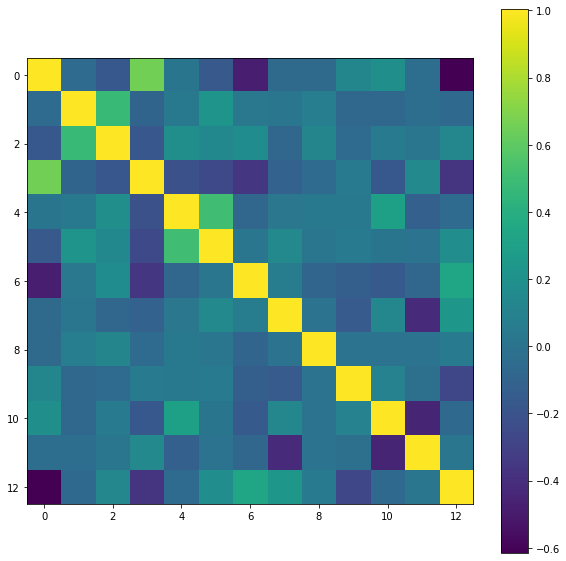

beta


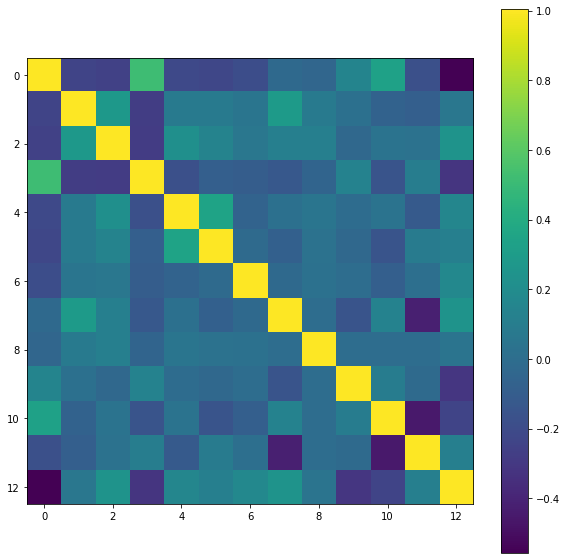

gamma


high_gamma


In [9]:
## correlations

for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    dm = patsy.dmatrix(formula, dataframes[band])
    features = dm.design_info.column_names

    plt.figure(figsize=(10,10))
    plt.imshow(np.cov(x, rowvar=False))
    plt.colorbar()
    plt.show()

In [10]:
# features